# Simulating Stellar Environments

## Stellar Environments
### Flyby Rate
There are three main characteristics needed to compute the initial conditions of a flyby star: the mass of the flyby star $m_\star$, the impact parameter $b_\star$, and the relative velocity or hyperbolic excess velocity $v_\star$. We found that these three parameters are the easiest to work with when drawing samples from distributions that define various stellar environments. Differences between stellar environments are essentially delineated by the stellar density $n$, the stellar mass distribution $\mathcal{M}$, and the stellar velocity dispersion $\bar{v}$. The average encounter rate can then be calculated using ([Adams 2010](https://ui.adsabs.harvard.edu/abs/2010ARA%26A..48...47A/abstract))
$$ \Gamma = \langle n \sigma \bar{v} \rangle$$
where $\sigma$ is the cross-section of the system of interest. In practice the average encounter rate is calculated using the product of the averages rather than the average of the products. 

The table below is a summary of the stellar densities $n$, typical velocities $\bar{v}$, and mass ranges $m_\star$ for the stellar environments we investigate below. See Brown & Rein (2022) for details and citations.

<table>
    <tr>
        <td><b>Environment</b></td>
        <td><b>Stellar Density</b></td>
        <td><b>Typical Speeds</b></td>
        <td><b>Mass Range</b></td>
    </tr>
    <tr>
        <td></td>
        <td>$n$ $[\mathrm{pc}^{-3}]$</td>
        <td>$\bar v$ [$\mathrm{km\,s}^{-1}$]</td>
        <td>$m_\star$ $[M_\odot]$</td>
    </tr>
    <tr>
        <td>Local Neighbourhood</td>
        <td>0.14</td>
        <td>20.8</td>
        <td>0.08—8</td>
    </tr>
    <tr>
        <td>Open Cluster</td>
        <td>100</td>
        <td>1</td>
        <td>0.08—100</td>
    </tr>
    <tr>
        <td>Globular Cluster</td>
        <td>1,000</td>
        <td>10</td>
        <td>0.08—1</td>
    </tr>
    <tr>
        <td>Milky Way Bulge</td>
        <td>50</td>
        <td>120</td>
        <td>0.08—10</td>
    </tr>
    <tr>
        <td>Milky Way Core</td>
        <td>10,000</td>
        <td>170</td>
        <td>0.08—10</td>
    </tr>
</table>


The three main components of the stellar flyby ($m_\star$, $v_\star$, and $b_\star$) can be drawn from the stellar mass distribution, the stellar velocity distribution (defined by the velocity dispersion), and uniformly across the cross-sectional area. 

#### Stellar Mass Distribution
The stellar mass distribution $\mathcal{M}$ can be calculated from an initial mass function ([IMF](https://en.wikipedia.org/wiki/Initial_mass_function)) which is often given as a probability distribution function ([PDF](https://en.wikipedia.org/wiki/Probability_distribution)). We draw samples from different IMFs by inverting the relevant cummulative probability distribution ([CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function)) in combination with a uniform distribution between 0 and 1. Our IMF distributions smoothly combine the IMF for single stars given in equation (17) by Chabrier ([2003](https://ui.adsabs.harvard.edu/abs/2003PASP..115..763C/abstract)) for stars less than $1\,M_\odot$ with the standard power-law IMF from Salpeter ([1955](https://ui.adsabs.harvard.edu/abs/1955ApJ...121..161S/abstract)) for stars more than $1\,M_\odot$.

#### Stellar Velocity Distribution
The stellar velocities within a stellar environment are characterized by the measured stellar [velocity dispersion](https://en.wikipedia.org/wiki/Velocity_dispersion), $\bar{v}$. By assuming a [Maxwell–Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell–Boltzmann_distribution) the velocity dispersion (variance) determines the scale factor which allows for a standard way for us to draw velocity samples. However, `REBOUND` requires eccentricity as a parameter rather than speed, but eccentricity can be calculated using ([Spurzem et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...697..458S/abstract))
$$e_\star = \sqrt{1 + \left(\frac{b_\star v_\infty^2}{G(M_T + m_\star)}\right)^2}$$
where $M_T$ is the total mass in the system.

#### Impact Parameter Distribution
We sample impact parameters uniformly over the cross-sectional area. In principle we should consider all flybys of any distance, in practice there are limiting factors to how much of an effect a particular flyby will have. Thus, if necessary, we can determine before hand what a reasonable maximum distance should be (see implementation details below). A convenient way to uniformly sample impact parameters over the cross-sectional area is to draw from $R_\mathrm{max}\sqrt{\mathit{U}[0,1]}$, where $R_\mathrm{max}$ is the reasonable maximum distance to consider and $\mathit{U}[0,1]$ is a uniform distribution between 0 and 1, see ([Zink et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..232Z/abstract)). However, `REBOUND` requires semi-major axis instead of impact parameter, but it can easily be computed with
$$a_\star = -\frac{b_\star}{\sqrt{e_\star^2 - 1}}.$$
Additionally, when using the cross-section to compute the flyby rate $\Gamma$, for some stellar environments it is important to consider that effects of gravitational focusing. This is done by considering the closest distance of interest (perihelion) and solving for the impact parameter which can be calculated using ([Tremaine 2023](https://ui.adsabs.harvard.edu/abs/2023dyps.book.....T/abstract))
$$b_\star = q_\star\sqrt{1 + \frac{2G (M_T + m_\star)}{q_\star v_\infty^2}}.$$

### Three-body system flyby (Sun-Neptune and flyby star).
From the [Basics](./Basics.ipynb) notebook, we can determine the likelihood a stellar flyby changes a Sun-Neptune system by a particular amount and compare it to the likelihood a flyby comes within a certain distance.

First we'll import the neccessary modules and we'll also make sure to use a colour blind friendly palette.

In [1]:
import rebound
import airball
import airball.units as u
import numpy as np
from joblib import Parallel, delayed
import time
import matplotlib.pyplot as plt

%matplotlib inline

# Use a backend LaTeX for better plots.
import matplotlib

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{mathabx}"
)
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = "Computer Modern"
%config InlineBackend.figure_format = 'retina'

from scipy.integrate import cumulative_trapezoid as cumtrapz
import warnings

import matplotlib.style as style

style.use("tableau-colorblind10")


%load_ext autoreload
%autoreload 2

In [2]:
# Define our Sun-Neptune binary system.
msun = 1.0  # Msun
mnep = 5.151383772628674e-05  # Msun
anep = 30.277621432690655  # AU
enep = 0.012971767987242259

# Define our Stellar Environments.
env = [
    airball.LocalNeighborhood(),
    airball.OpenCluster(),
    airball.GlobularCluster(),
    airball.GalacticBulge(),
    airball.GalacticCore(),
]

# Parameters of the stellar environment sampling.
ceiling = np.array(
    [
        0.41841721861423963880,
        0.45855064907794645945,
        0.23153979998111287597,
        0.39996971538637410282,
        0.36852421088379688774,
    ]
)
floor = (
    2**-53
)  # 2.653030381944522e-13 # Numerical Floor = 2^{-53} * sqrt{Nsteps} limit of floating point precision.

#### Setup a two-body simulation and run a flyby simulation.
We define a function that returns a consistent `REBOUND` Simulation setup for convenience and reproducibility.

In [3]:
def setup(
    sun_mass=1,
    planet_mass=5.151383772628674e-05,
    planet_a=30.27762143269065,
    planet_e=0.012971767987242259,
    planet_inc=0,
    planet_omega=0,
    planet_Omega=0,
    planet_f=0,
):
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=sun_mass)
    sim.add(
        m=planet_mass,
        a=planet_a,
        e=planet_e,
        inc=planet_inc,
        omega=planet_omega,
        Omega=planet_Omega,
        f=planet_f,
    )

    sim.integrator = "whckl"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.05 * sim.particles[1].P
    sim.move_to_com()
    return sim


Below we compute the expected time until a flyby of a particular perturbation strength or greater for each stellar environment. We do this for each environment by drawing random samples and first computing an analytical estimate for the perturbation strength. We bin these estimates and compute a 3-body flyby simulation for that bin. If we draw a sample and we already have more than `nsamples` for a given bin, then we tally the sample but do *not* run a 3-body simulation for it. We continue collecting samples until we've 'filled' all the bins with `nsamples` or until we reach some maximum number of total samples drawn.

After the Monte Carlo process is finished, we consolidate the samples and compare them to the total number of samples drawn for each bin. We then weight the n-body samples respectively and extrapolate as if we had run more. We compute a weighted histogram of the data, and then cumulatively integrate the number of samples to determine the length of time it would take to have a stellar flyby of a particular perturbation strength or greater.

Brown & Rein (2022) used 250 bins with 100 samples for each bin and $10^{9}$ as the overall maximum number of samples to draw.

The following took about 3 minutes to run on an M2 Pro Macbook Pro. 

In [30]:
def low_mem_sampling(index, nbins=250, nsamples=100, batch_size=1e6, nmax=5e7):
    """
    This function samples a stellar environment and returns the analytical and numerical estimates for the expected time until stellar flyby of perturbation strength X or greater.

    nbins : the number of bins
    nsamples : the number of n-body samples to run for each bin.
    batch_size : the number of samples to draw each step
    nmax : the maximum number of samples to draw.
    """

    samples_drawn = 0  # Keep track of the total number of samples drawn.
    significant_samples = np.zeros(
        nbins, dtype=int
    )  # Keep track of the total number of samples drawn for each bin.
    nbody_samples = np.zeros(
        nbins, dtype=int
    )  # Keep track of the number of n-body simulations run for each bin.
    nbody_results = np.zeros(
        (nbins, nsamples)
    )  # Preallocate the space for holding the n-body results.

    # Define the bins to range between the numerical floor and the top of the analytical range.
    bins = np.logspace(
        np.log10(floor), np.log10(ceiling[index] * (1.0 + 1.0 / nbins)), nbins + 1
    )

    ###### Low Memory Sampling ######
    sim = setup()
    e0 = sim.energy()
    iteration = 0
    while (nbody_samples < nsamples).any() and samples_drawn < nmax:
        # Draw a sample of random stars.
        stars = env[index].random_stars(batch_size)
        samples_drawn += batch_size
        # Compute the analytical estimate for the change in energy/semi-major axis.
        dE = np.abs(airball.relative_energy_change(sim, stars))
        # Select all the stars that give an analytical estimate for the change in energy that is above the numerical floor.
        substars = stars[dE > floor]
        # Determine which bins the N-body samples will be in.
        hist = np.histogram(dE, bins=bins)[0]
        nums = np.arange(substars.N, dtype=int)
        dbined = np.digitize(dE[dE > floor], bins=bins) - 1
        # The indices of the subset of stars for each bin.
        inds = [nums[dbined == i] for i in range(nbins)]
        # Track how many total samples fall within the relevant bins.
        significant_samples += hist

        # Check if more N-body samples are needed for the particular bin and run N-body integrations if necessary.
        more_needed = nbody_samples < nsamples
        sim_res = []
        for i in range(nbins):
            if more_needed[i] and len(inds[i]) > 0:
                nsamples_needed = nsamples - nbody_samples[i]
                if len(inds[i]) < nsamples_needed:
                    samplestars = substars[inds[i]]
                    sout = airball.hybrid_flybys(setup(), samplestars, overwrite=False)
                else:
                    samplestars = substars[
                        np.random.choice(inds[i], size=nsamples_needed, replace=False)
                    ]
                    sout = airball.hybrid_flybys(setup(), samplestars, overwrite=False)
            else:
                sout = []
            sim_res.append(sout)

        for i in range(nbins):
            res = [np.abs((s.energy() - e0) / e0) for s in sim_res[i]]
            nbody_results[
                i, int(nbody_samples[i]) : int(nbody_samples[i]) + len(res)
            ] = res
        nbody_samples += np.array([len(r) for r in sim_res])
        iteration += 1

    ###### Consolidate the Data ######

    # Use the edges of the bins to compute the centre of the bins and reduce the "number of bins" from nbins+1 to nbins
    mbins = 10 ** ((np.log10(bins[:-1]) + np.log10(bins[1:])) / 2)

    # Calculate the weights to compute an estimate for the distribution of flybys.
    # The weights are the ratio between the number of samples that would've been in the bin
    #  divided by the number of N-body simulations ran from the initial conditions that resulted in that bin.
    weights = np.zeros(nbody_samples.shape, dtype=int)
    nonzero_inds = nbody_samples != 0
    weights[nonzero_inds] = (
        significant_samples[nonzero_inds] / nbody_samples[nonzero_inds]
    )
    # Duplicate the weights relative to the number of samples for each bin.
    wgts = np.array([weights] * nsamples).T

    # Compute the number of expected samples in a given amount of time (here we use 5 Gyrs).
    T = 5e9 * u.yr  # 5 Gyrs
    N_expected = (env[index].encounter_rate * T).decompose()

    # Redistribute the n-body samples because the theoretical values don't always match the numerical values for the relative change in energy.
    nbody_flat = nbody_results.flatten()
    numbins = np.logspace(
        np.log10(np.min(nbody_flat[np.nonzero(nbody_flat)])),
        np.log10(np.max(nbody_results)),
        bins.shape[0],
    )
    mnumbins = 10 ** ((np.log10(numbins[:-1]) + np.log10(numbins[1:])) / 2)
    # Weight the redistribution based on the number of samples drawn for the theoretical bins.
    a_orig, b = np.histogram(
        nbody_flat, weights=wgts.flatten(), bins=numbins, density=False
    )

    # Rescale the samples by the number of expected samples in the arbitrary amount of time (divide out the choice of 100 Gyrs).
    fac = samples_drawn / N_expected
    # Append zero (0) to the histogram so that we have the same array length after cumulatively integrating.
    a = np.append(a_orig, 0) / fac
    # Cumulatively integrate the weighted n-body data and to compute the number of flybys we expect for a particular perturbation strength or greater.
    y = cumtrapz(a[::-1])[::-1]

    # Do the same for the analytical samples.
    a = np.append(significant_samples, 0) / fac
    y2 = cumtrapz(a[::-1])[::-1]

    # Rescale the results by the number of expected samples in the arbitrary amount of time (divide out the choice of 100 Gyrs).
    #  Catch any divide by zero errors in case some bins had no samples in them.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y = T / y
        y2 = T / y2

    analytical = np.array([mbins, y2])
    numerical = np.array([mnumbins, y])
    return analytical, numerical

In [27]:
res = []
for i in [0, 2, 3, 4]:
    # for i in range(5):
    start = time.time()
    print(f"Start {env[i].name}...", end=" ")
    res.append(low_mem_sampling(index=i, nmax=3e6))
    print(f"End {env[i].name} :: {time.time() - start:,.2f}s")

Start Local Neighborhood... 3000000.0
End Local Neighborhood :: 24.48s
Start Globular Cluster... 3000000.0
End Globular Cluster :: 31.19s
Start Milky Way Bulge... 3000000.0
End Milky Way Bulge :: 20.45s
Start Milky Way Core... 3000000.0
End Milky Way Core :: 20.23s


In [5]:
results = Parallel(n_jobs=len(env))(
    delayed(low_mem_sampling)(index=i, nmax=1e6) for i in range(len(env))
)

NameError: name 'Parallel' is not defined

In [6]:
results = res

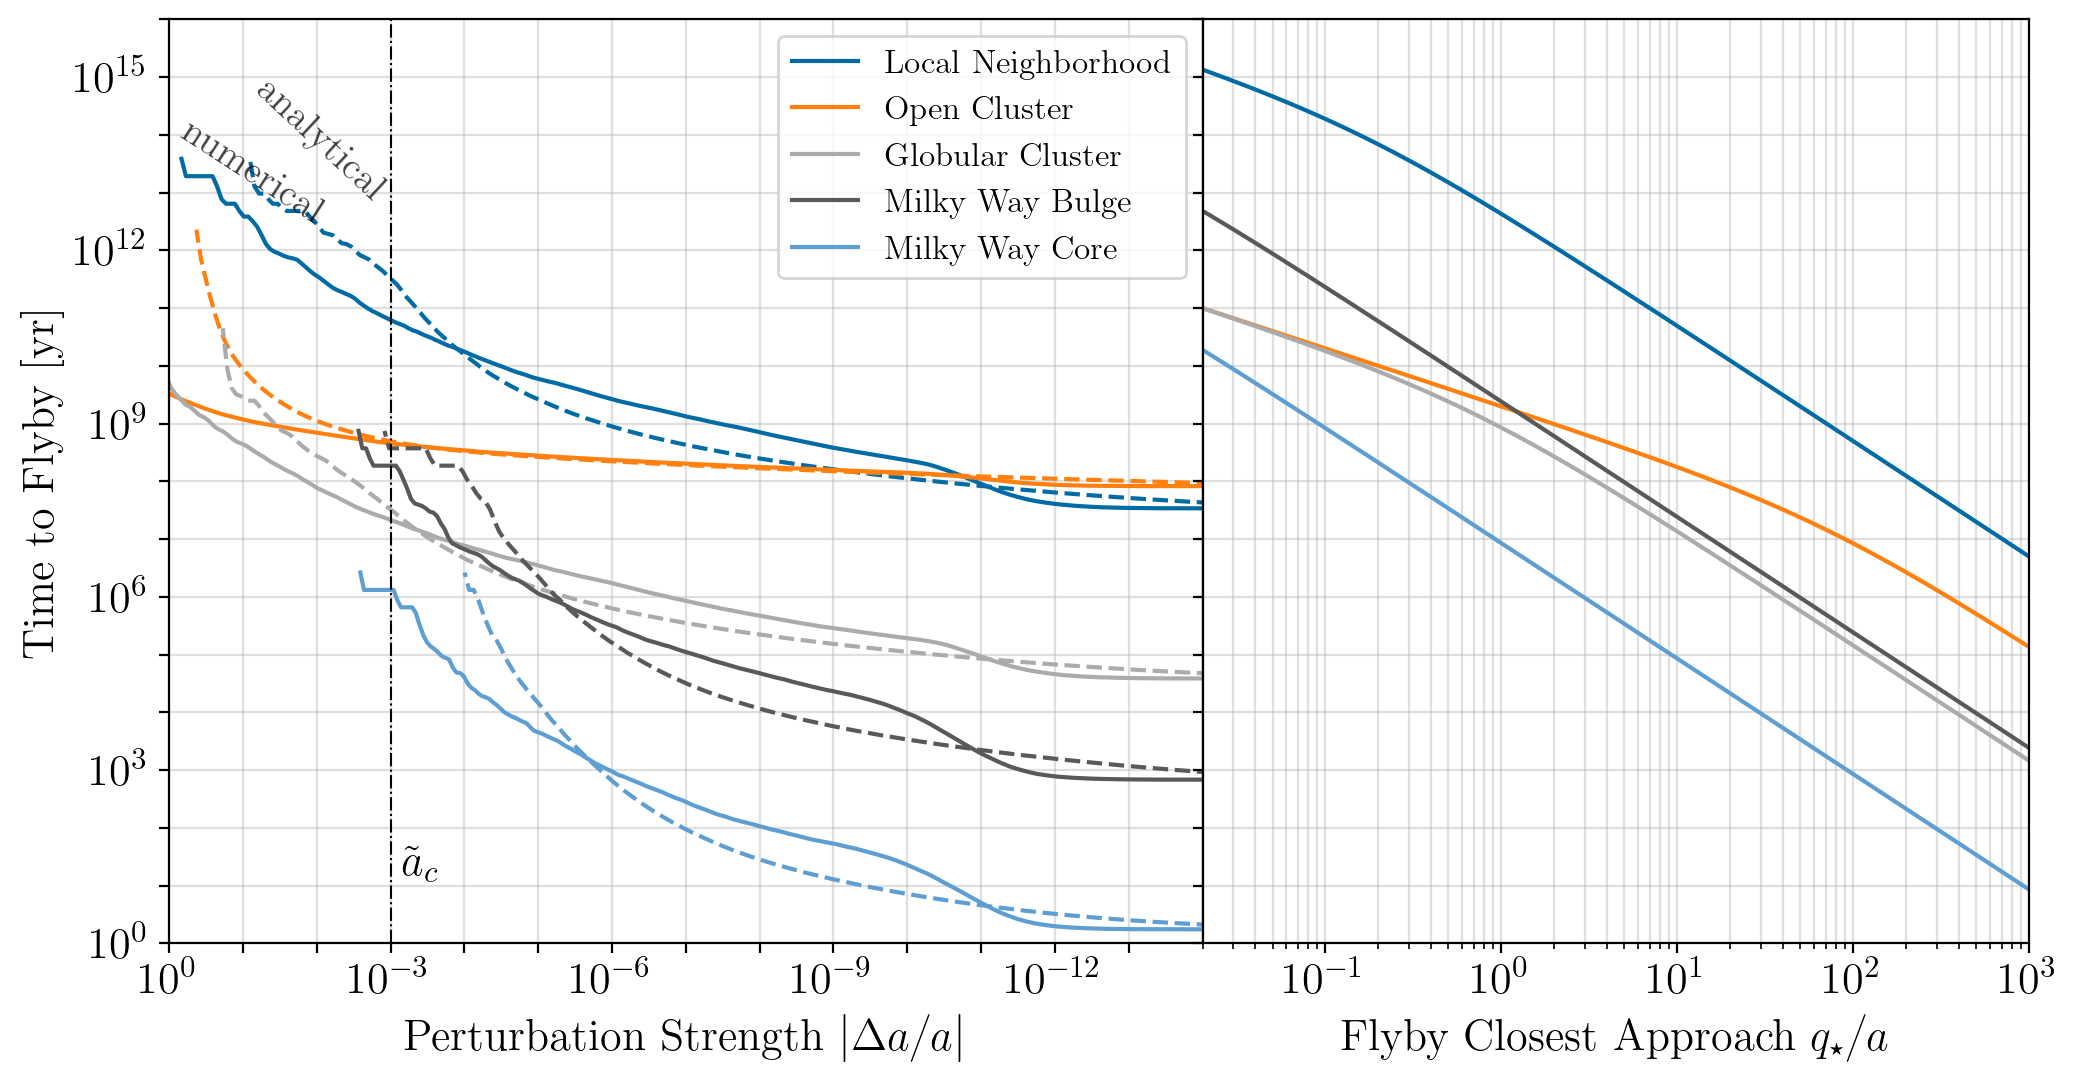

In [10]:
colours = ["C0", "C1", "C2", "C3", "C4"]
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(
    1, 2, figsize=(12, 6), sharey=True, gridspec_kw={"width_ratios": [1.25, 1]}
)
# # Uncomment to plot the data from the Brown & Rein (2022) first.
# # results = []
# for index in range(len(env)):
#     x,y = np.load('examples_data/stellar-environments/{0}_numerical_estimate.npy'.format(env[index].short_name))
#     x2,y2 = np.load('examples_data/stellar-environments/{0}_analytic_estimate.npy'.format(env[index].short_name))
#     # if index == 1: results.append([[x,y], [x2,y2]])
#     # elif index > 1: results.append(res[index-1])
#     # else: results.append(res[index])
#     ax[0].loglog(x, y, '-', c=colours[index], alpha=0.33)
#     ax[0].loglog(x2, y2, '--', c=colours[index], alpha=0.33)
q = np.logspace(-1, 4.5, 10_000)
for index in range(len(env)):
    analytic, numerical = results[index]
    ax[0].loglog(
        numerical[0], numerical[1], ls="-", c=colours[index], label=env[index].name
    )
    ax[0].loglog(analytic[0], analytic[1], ls="--", c=colours[index])
    ax[1].loglog(
        q / anep,
        1
        / (
            airball.tools.encounter_rate(
                n=env[index].density,
                v=env[index].velocity_dispersion,
                q=q,
                M=(1 * u.solMass + env[index].median_mass),
            )
        ).to(u.stars / u.yr),
        "-",
        c=colours[index],
    )

ax[0].axvline(1e-3, c="k", ls="-.", lw=0.75)
ax[0].text(7e-4, 15.5, r"$\tilde{a}_c$")
ax[0].text(8e-2, 7.5e12, r"analytical", rotation=-43, size=14, alpha=0.75)
ax[0].text(8e-1, 3.0e12, r"numerical", rotation=-33, size=14, alpha=0.75)

ax[0].set_xlabel(r"Perturbation Strength $|\Delta a/a|$")
ax[0].set_ylabel(r"Time to Flyby [yr]")
ax[0].legend(loc=1, prop={"size": 12})
ax[1].set_xlabel(r"Flyby Closest Approach $q_\star/a$")

xticks = np.logspace(-13, 0, 14)
ax[0].set_xticks(xticks)
for l, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if l % 3 != 1:
        label.set_visible(False)
ax[0].set_xlim([1, 1e-14])
ax[1].set_xlim([2e-2, 1e3])

for i in range(2):
    ax[i].grid(True, which="both", alpha=0.4)
    yticks = np.logspace(0, 16, 17)
    ax[i].set_yticks(yticks)
    for l, label in enumerate(ax[i].yaxis.get_ticklabels()):
        if l % 3 != 0:
            label.set_visible(False)
    ax[i].set_ylim([1, 1e16])

plt.subplots_adjust(wspace=0.0, hspace=0.0)
fig.patch.set_facecolor("w")
# fig.savefig('time-to-flyby-environments-colorblind-friendly.pdf', bbox_inches=0, pad_inches=0.05)
plt.show()